In [1]:
import mne
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# --- Set paths ---
edf_path = Path("data/edf/P002_1_raw.edf")
json_path = Path("data/labels/sleep_block_spindle_output_P002_1.json")


In [ ]:
# --- Load EEG ---
raw = mne.io.read_raw_edf(edf_path, preload=True)
sfreq = raw.info['sfreq']
total_duration_sec = raw.n_times / sfreq
print(f"EEG Duration: {total_duration_sec / 3600:.2f} hours")



Extracting EDF parameters from /home/subahini/Desktop/Master Project/spindle-project/code/data/edf/P002_1_raw.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5967199  =      0.000 ... 29835.995 secs...


In [9]:
# --- Load spindle JSON ---
with open(json_path, 'r') as f:
    spindle_data = json.load(f)


    # json is in dictory form
print("Top-level JSON keys:", spindle_data.keys())
first_key = list(spindle_data.keys())[0]
print("First key:", first_key)
print("Value under that key:", spindle_data[first_key][:2])  # print first 2 entries
print("Type of value:", type(spindle_data[first_key][0]))

# Extract spindles from correct key
spindle_list = spindle_data["detected_spindles"]

# Standardize format
spindles = [
    {"channel": s["channel_names"][0], "start": float(s["start"]), "end": float(s["end"])}
    for s in spindle_list
]


Top-level JSON keys: dict_keys(['detected_spindles', 'nrem_duration', 'wake_duration', 'sleep_duration', 'rem_duration', 'spindle_rate', 'NREM_stages_from_reader_annotations', 'sleep_stages_parsed_list'])
First key: detected_spindles
Value under that key: [{'start': 1669.572, 'end': 1670.604, 'channels': [1], 'channel_names': ['c4-ref']}, {'start': 1676.488, 'end': 1677.004, 'channels': [1], 'channel_names': ['c4-ref']}]
Type of value: <class 'dict'>


In [10]:
# --- Segment EEG ---
window_len = 20.0  # seconds
step_size = 5.0   # seconds
train_limit_sec = 3 * 3600  # first 3 hours

starts = np.arange(0, train_limit_sec - window_len, step_size)

segments = []
labels = []

for start in starts:
    end = start + window_len
    label = 0
    for sp in spindles:
        if sp["start"] < end and sp["end"] > start:
            label = 1
            break
    segments.append((start, end))
    labels.append(label)


In [11]:
# --- DataFrame for inspection ---
df = pd.DataFrame({
    "start_sec": [s[0] for s in segments],
    "end_sec": [s[1] for s in segments],
    "label": labels
})

print(df.head())
print(f"Total segments: {len(df)}")
print(f"Spindle segments: {df['label'].sum()}")


   start_sec  end_sec  label
0        0.0     20.0      0
1        5.0     25.0      0
2       10.0     30.0      0
3       15.0     35.0      0
4       20.0     40.0      0
Total segments: 2156
Spindle segments: 1731


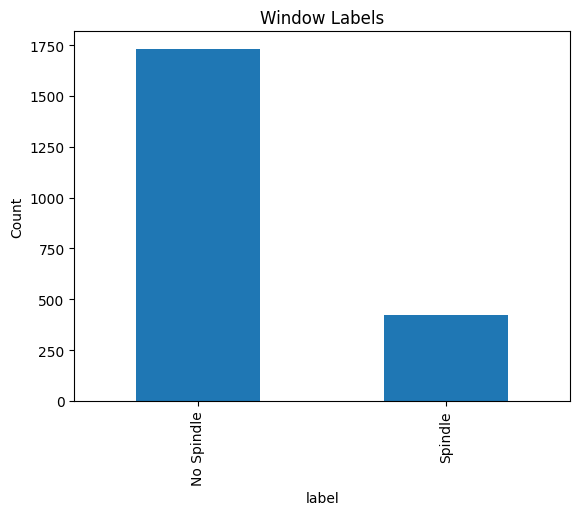

In [12]:
# --- Plot label distribution ---
df['label'].value_counts().plot(kind='bar')
plt.xticks([0, 1], ['No Spindle', 'Spindle'])
plt.title('Window Labels')
plt.ylabel('Count')
plt.show()

Using matplotlib as 2D backend.


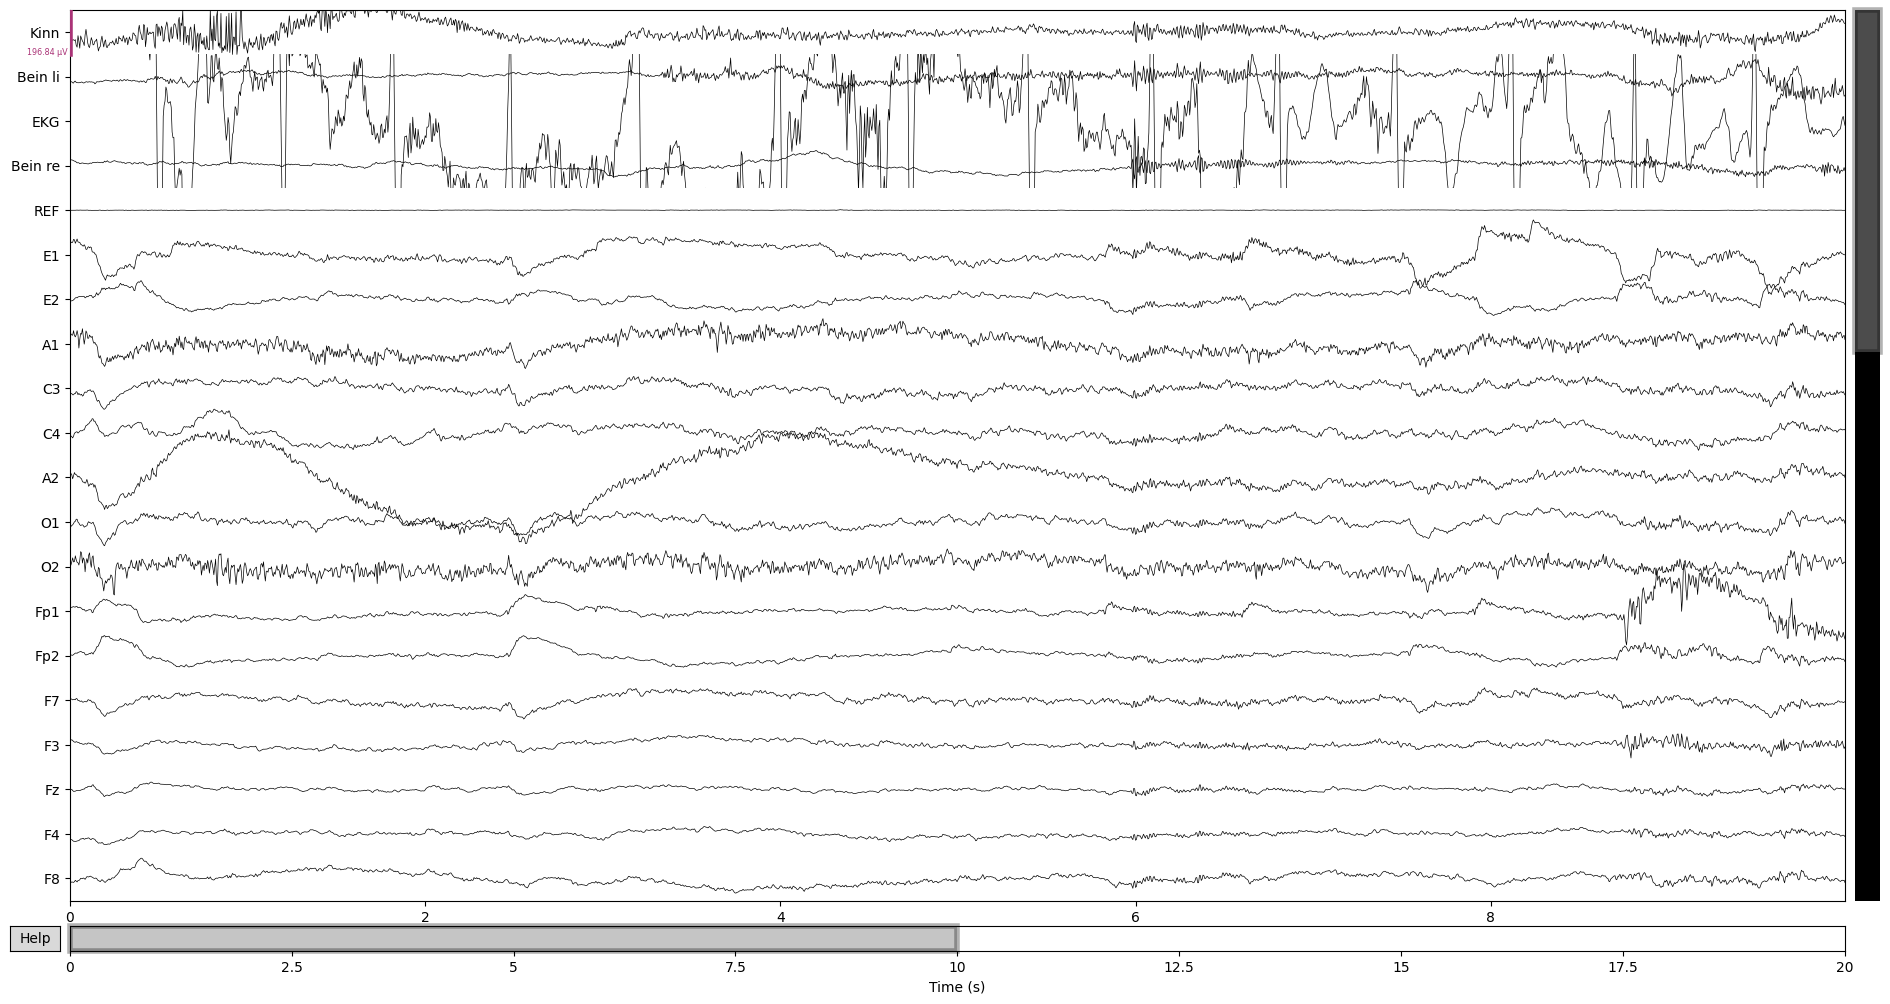

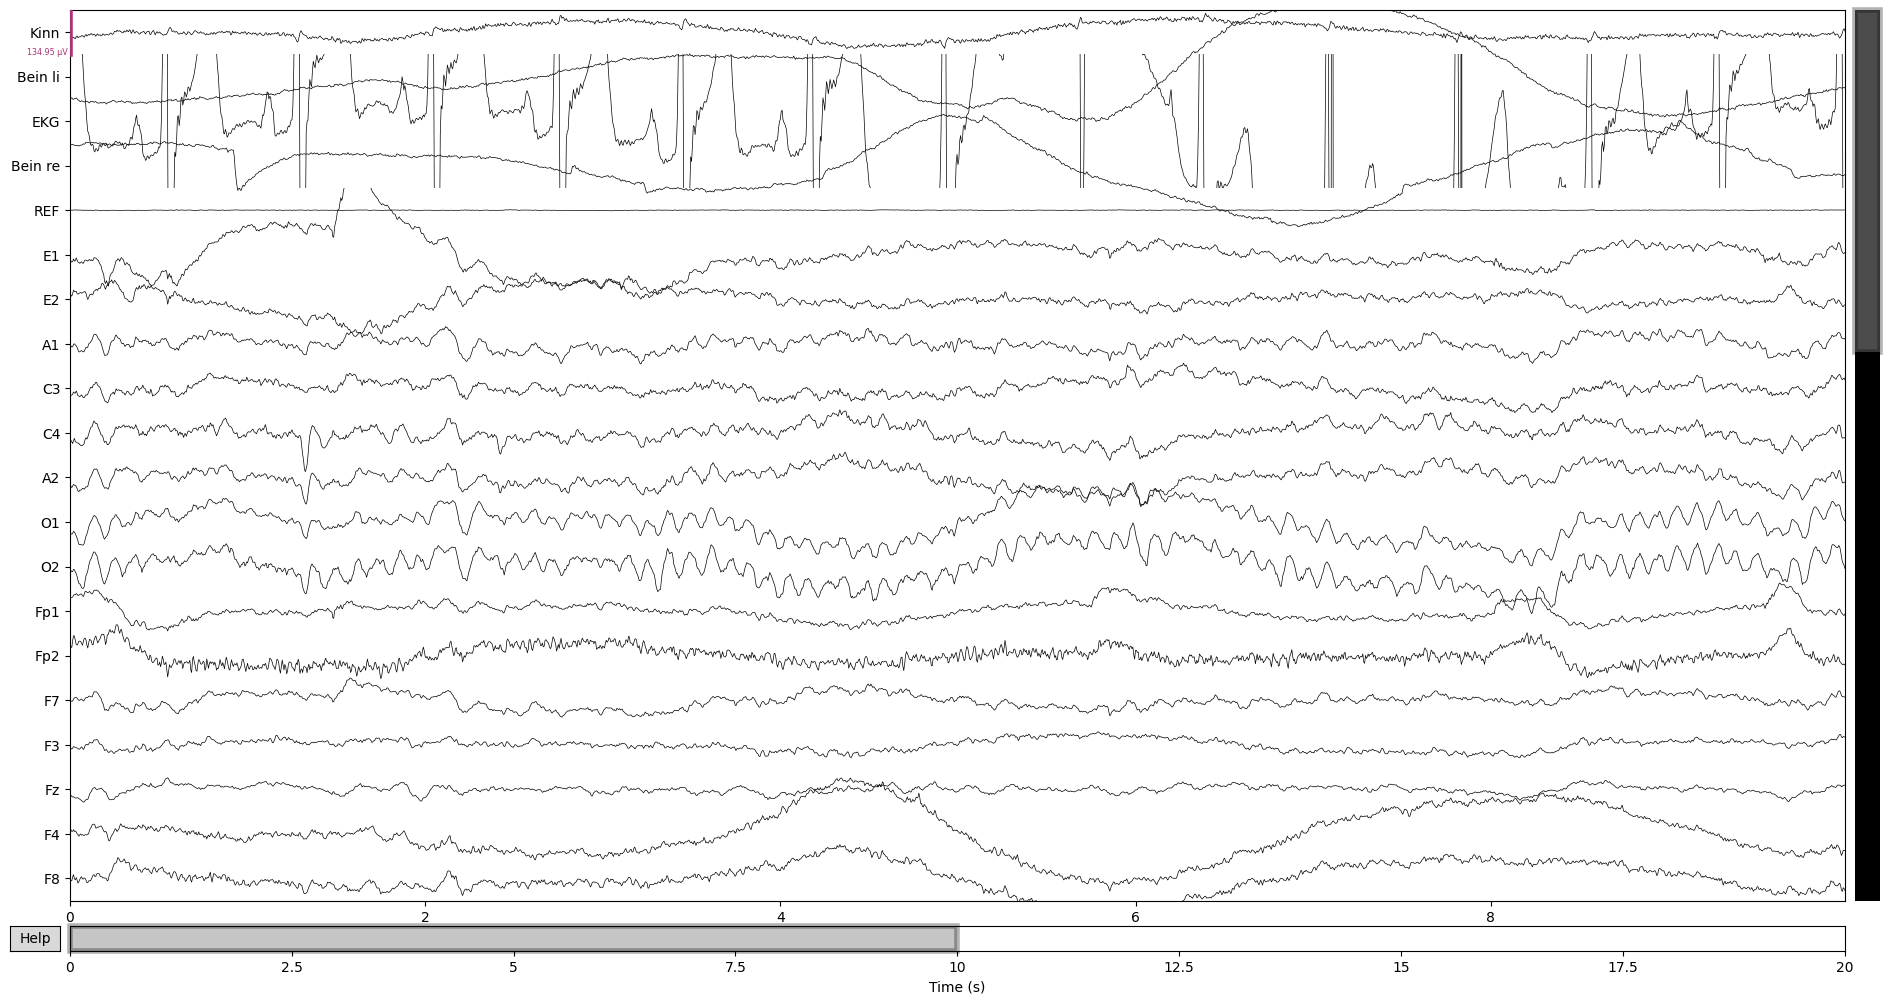

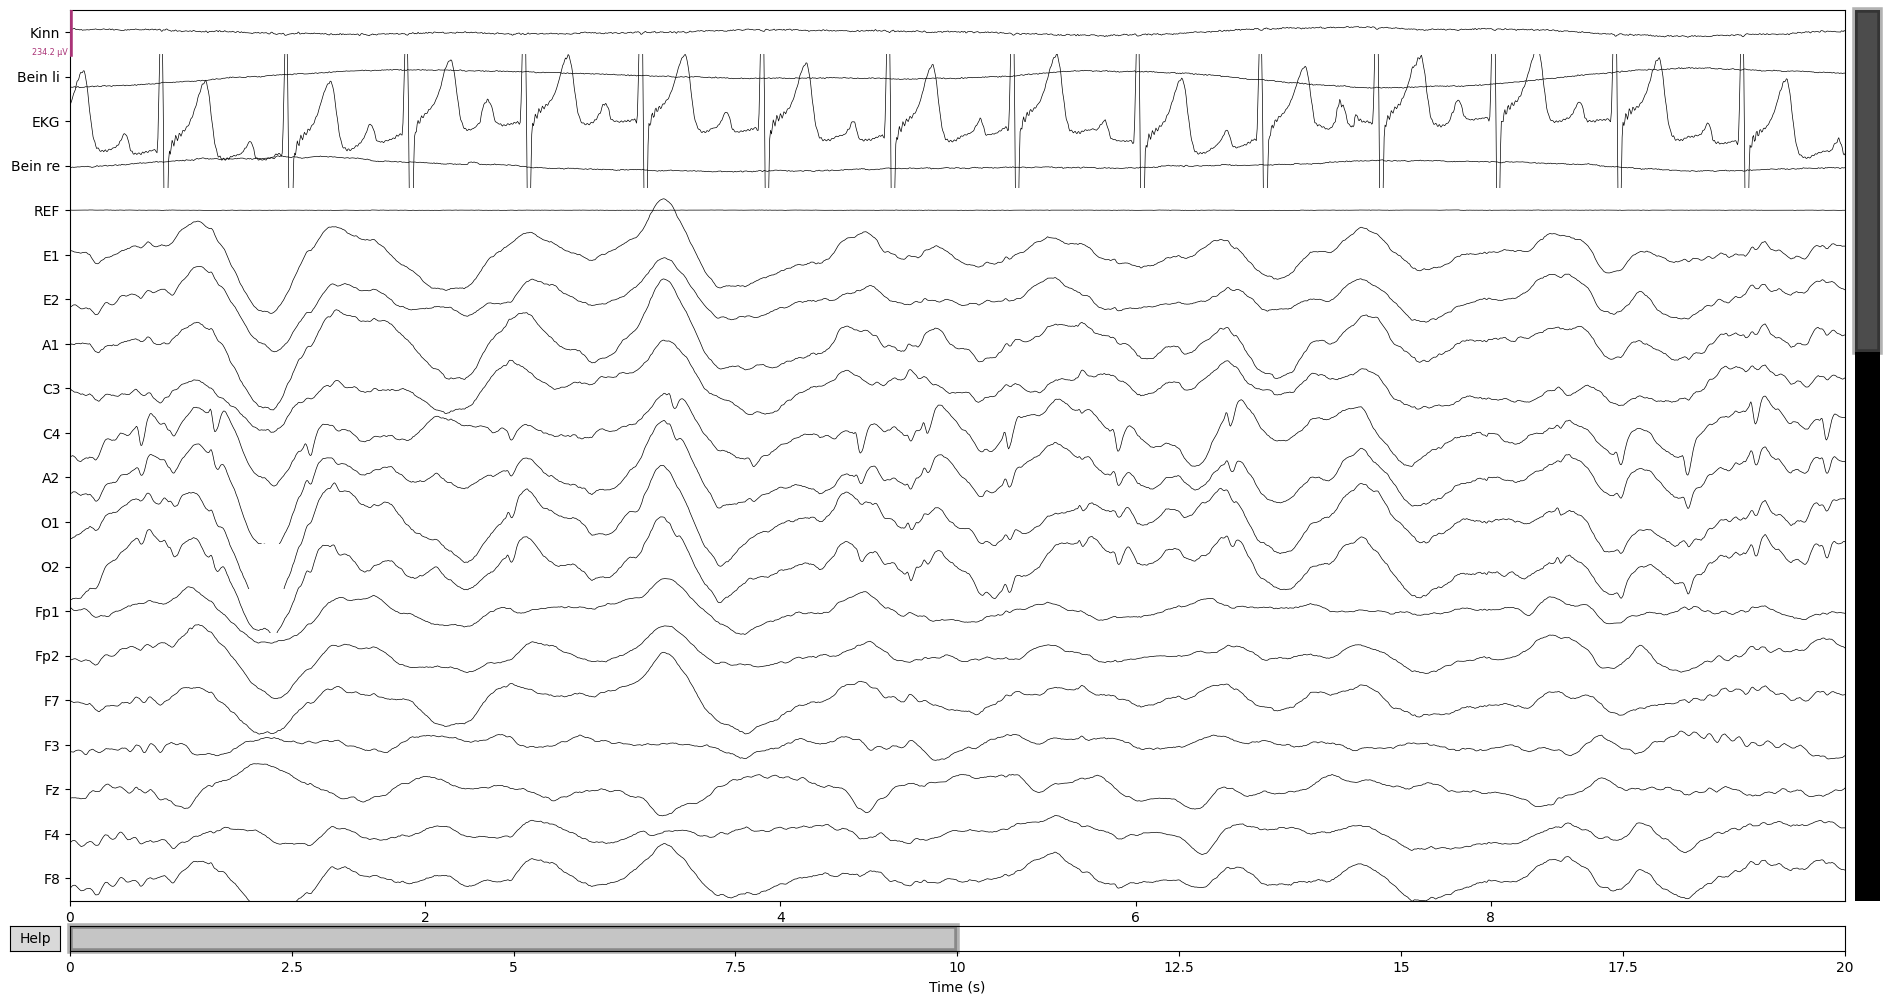

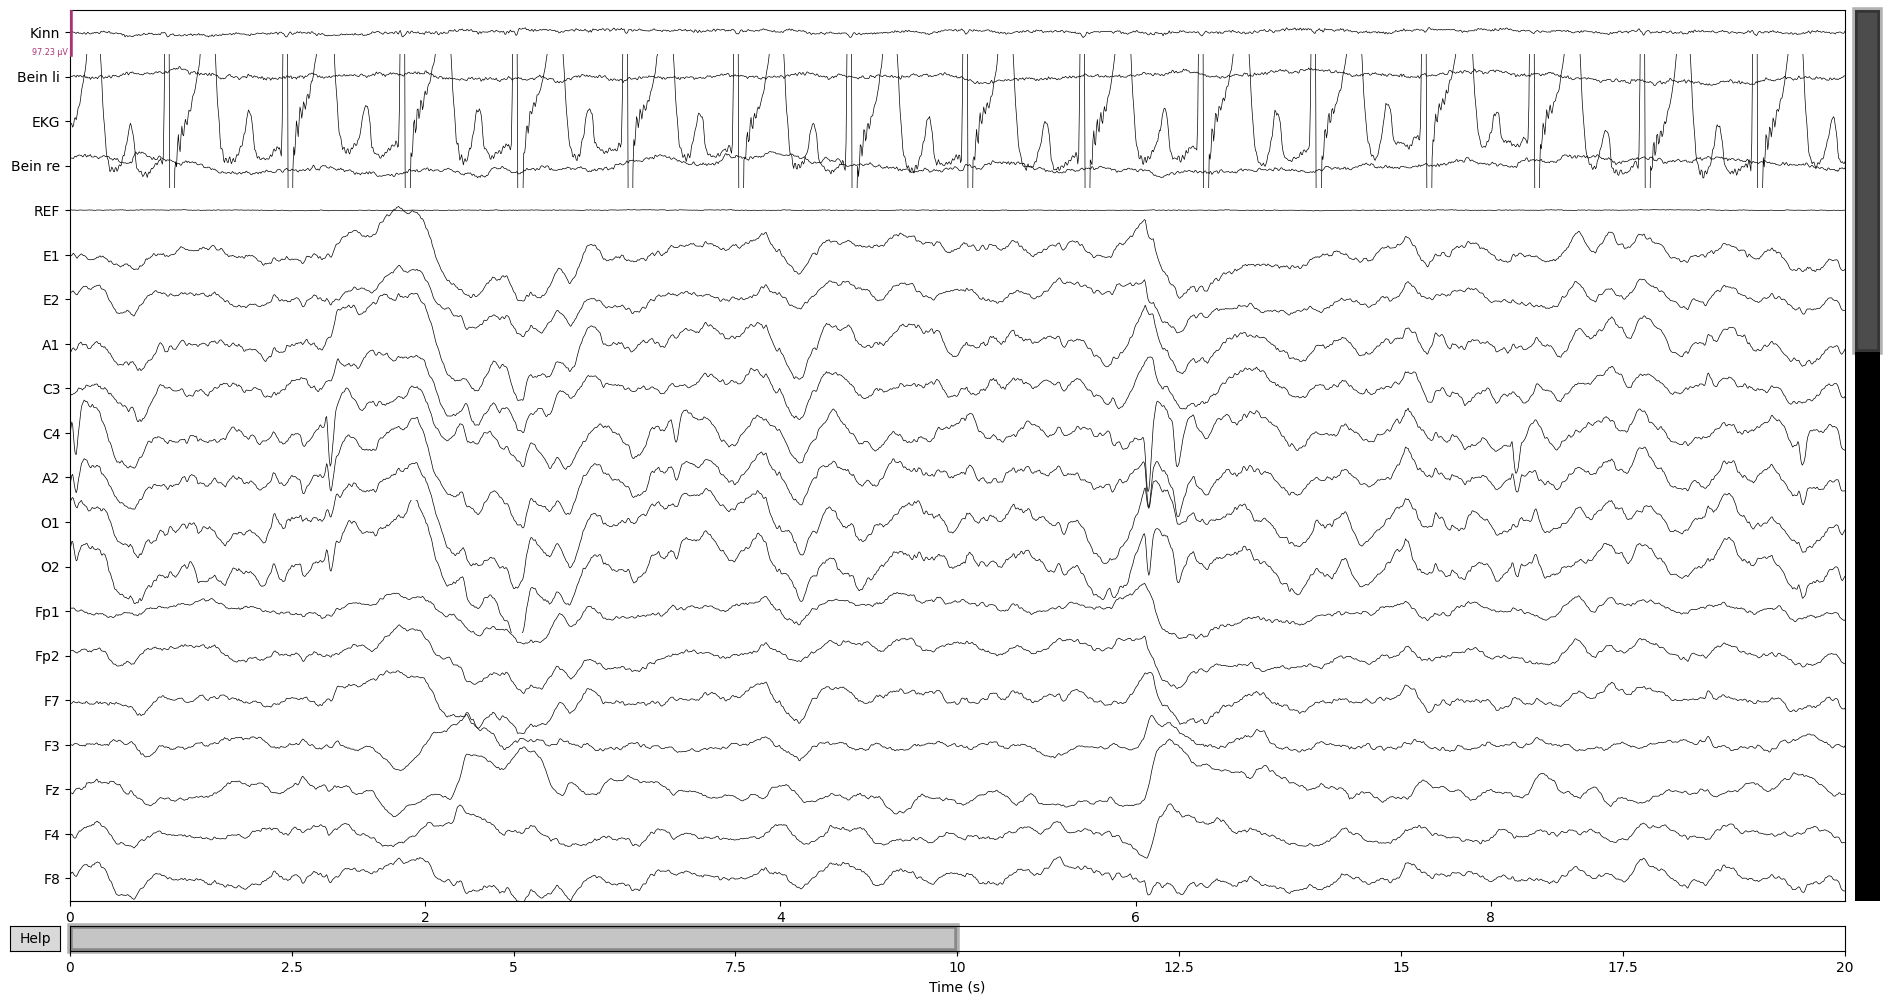

In [13]:
# --- Visualize 2 random spindle and non-spindle windows ---
def plot_sample_windows(df, raw, label_value, n=2):
    sample = df[df['label'] == label_value].sample(n)
    for _, row in sample.iterrows():
        start = row['start_sec']
        stop = row['end_sec']
        segment = raw.copy().crop(tmin=start, tmax=stop)
        segment.plot(scalings='auto', title=f"{'Spindle' if label_value else 'No Spindle'}: {start:.2f}-{stop:.2f}s")
df = pd.DataFrame({
    "start_sec": [s[0] for s in segments],
    "end_sec": [s[1] for s in segments],
    "label": labels
})
# Plot examples
plot_sample_windows(df, raw, label_value=0, n=2)  # No spindle
plot_sample_windows(df, raw, label_value=1, n=2)  # Spindle


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


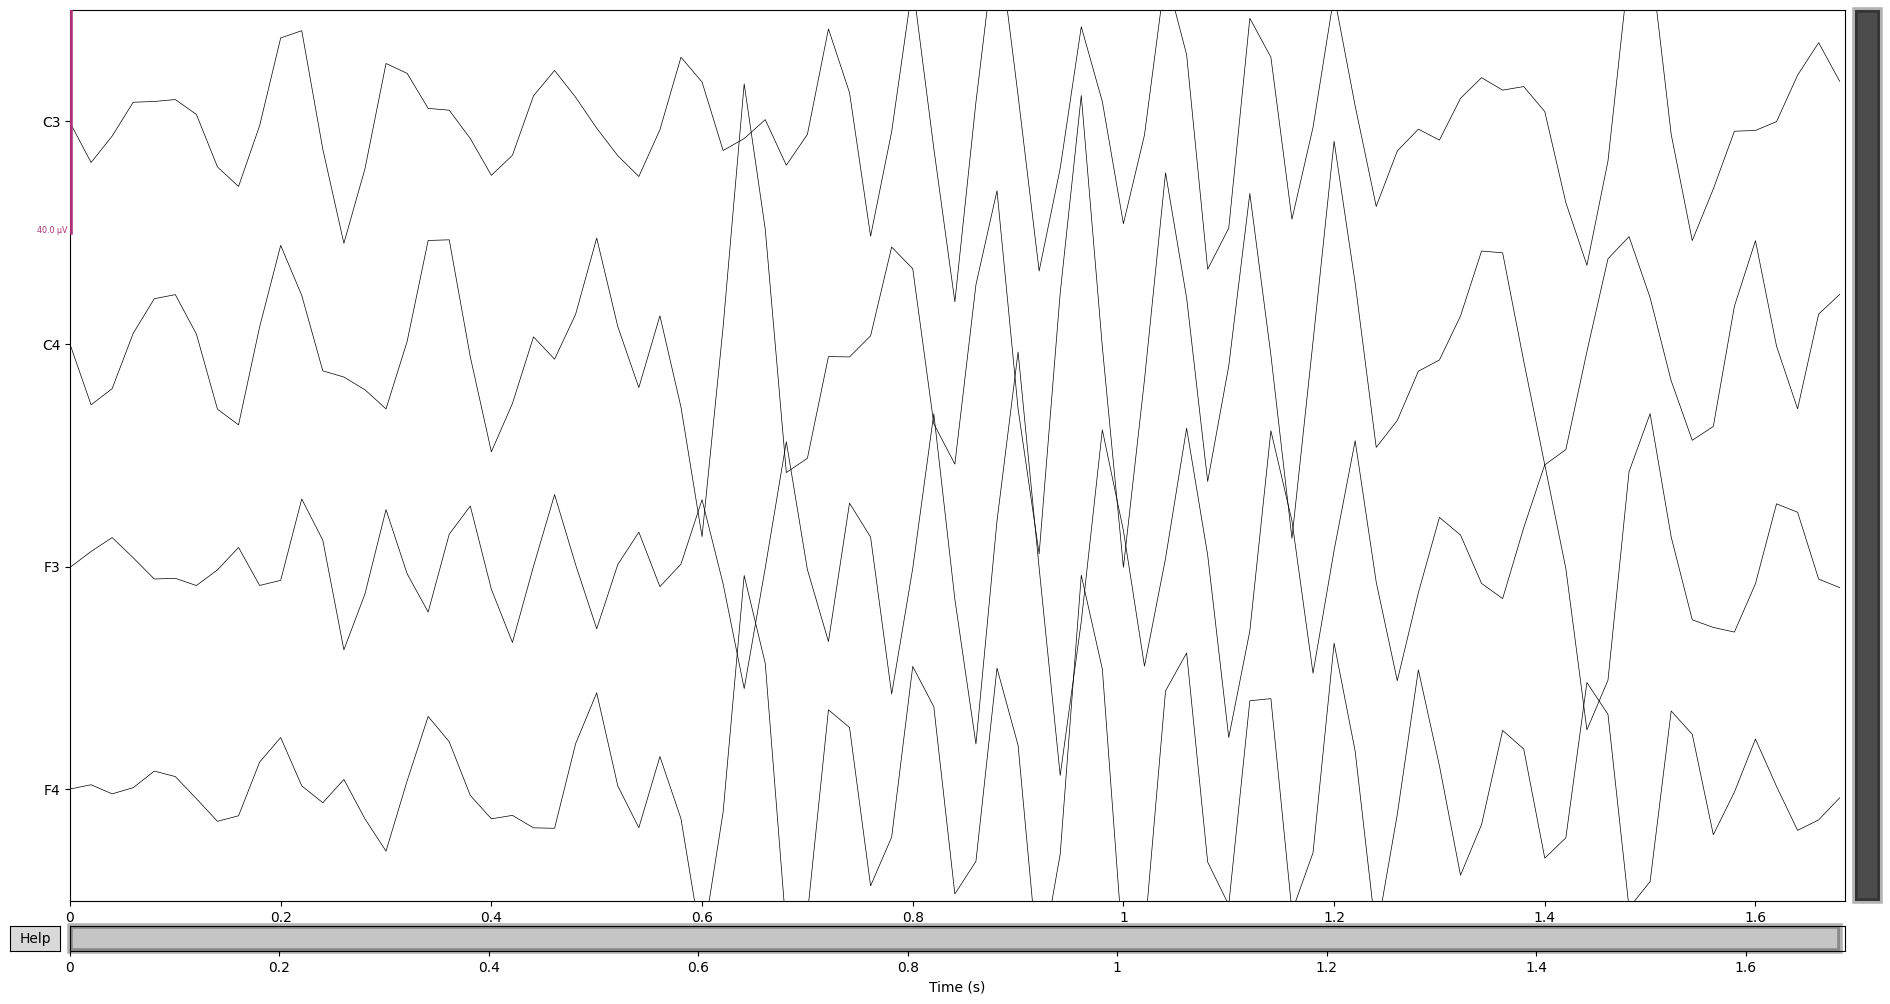

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


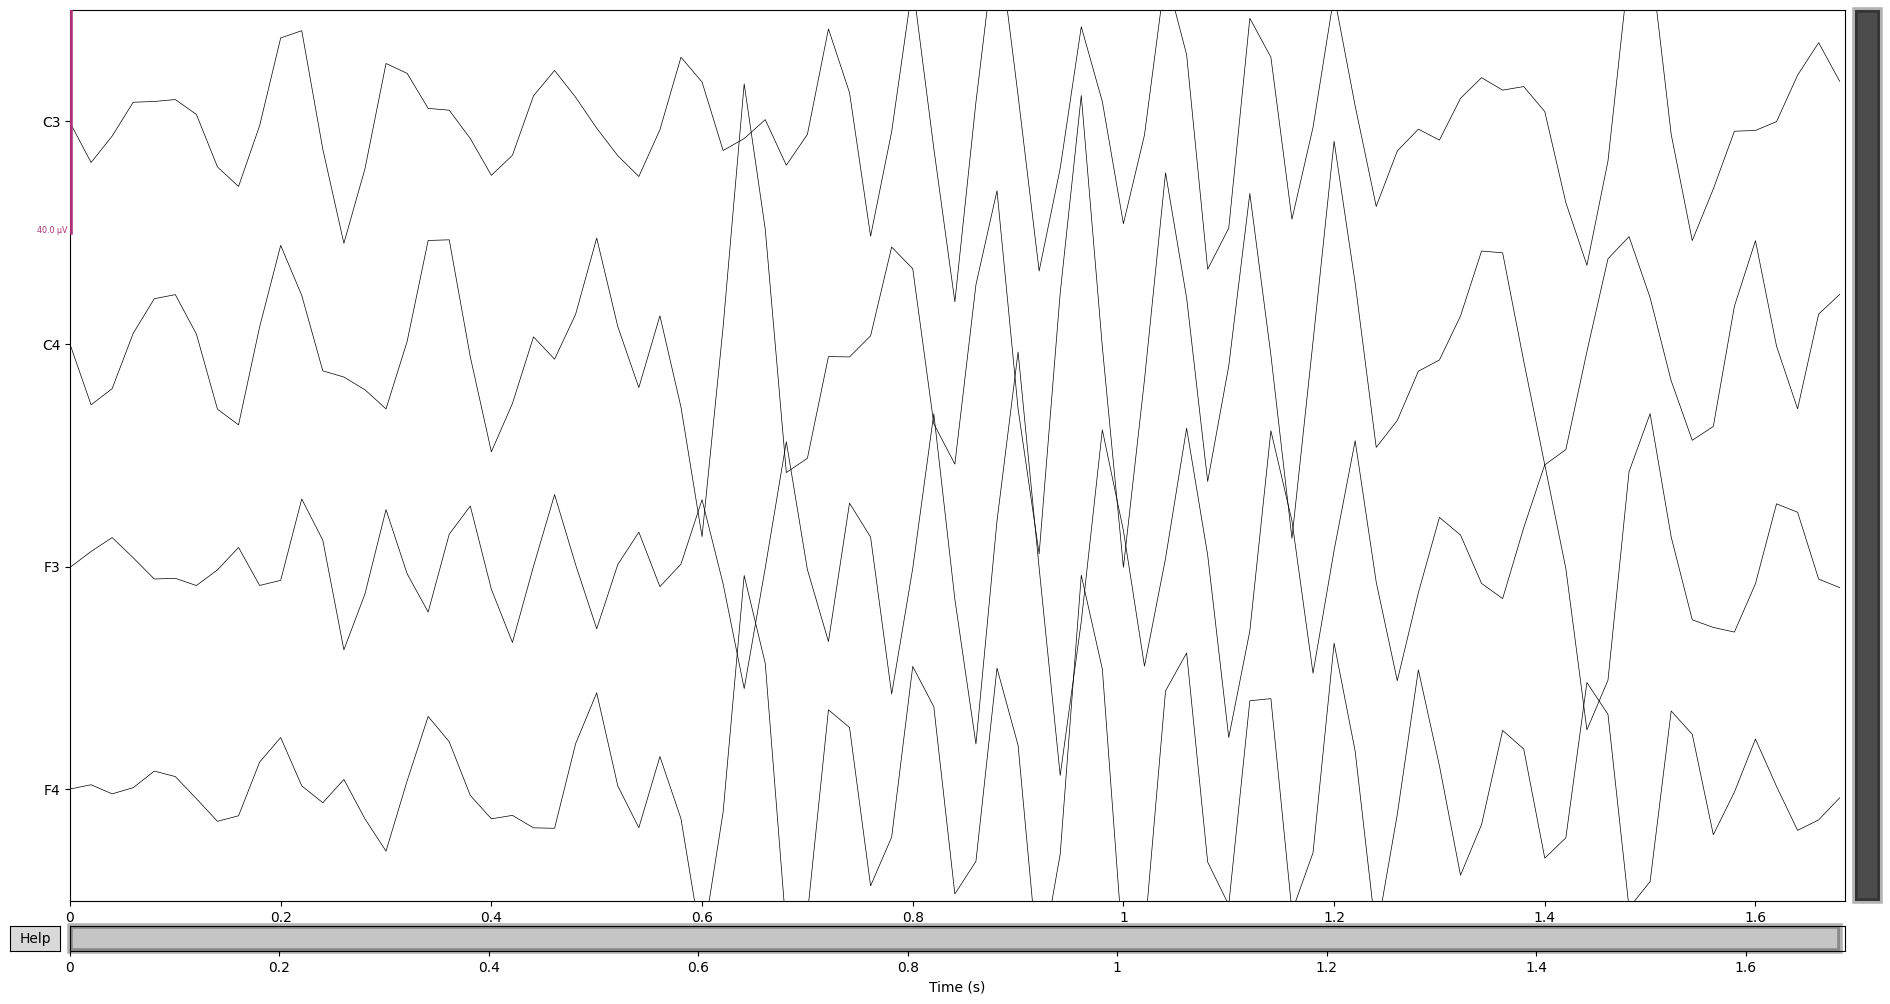

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


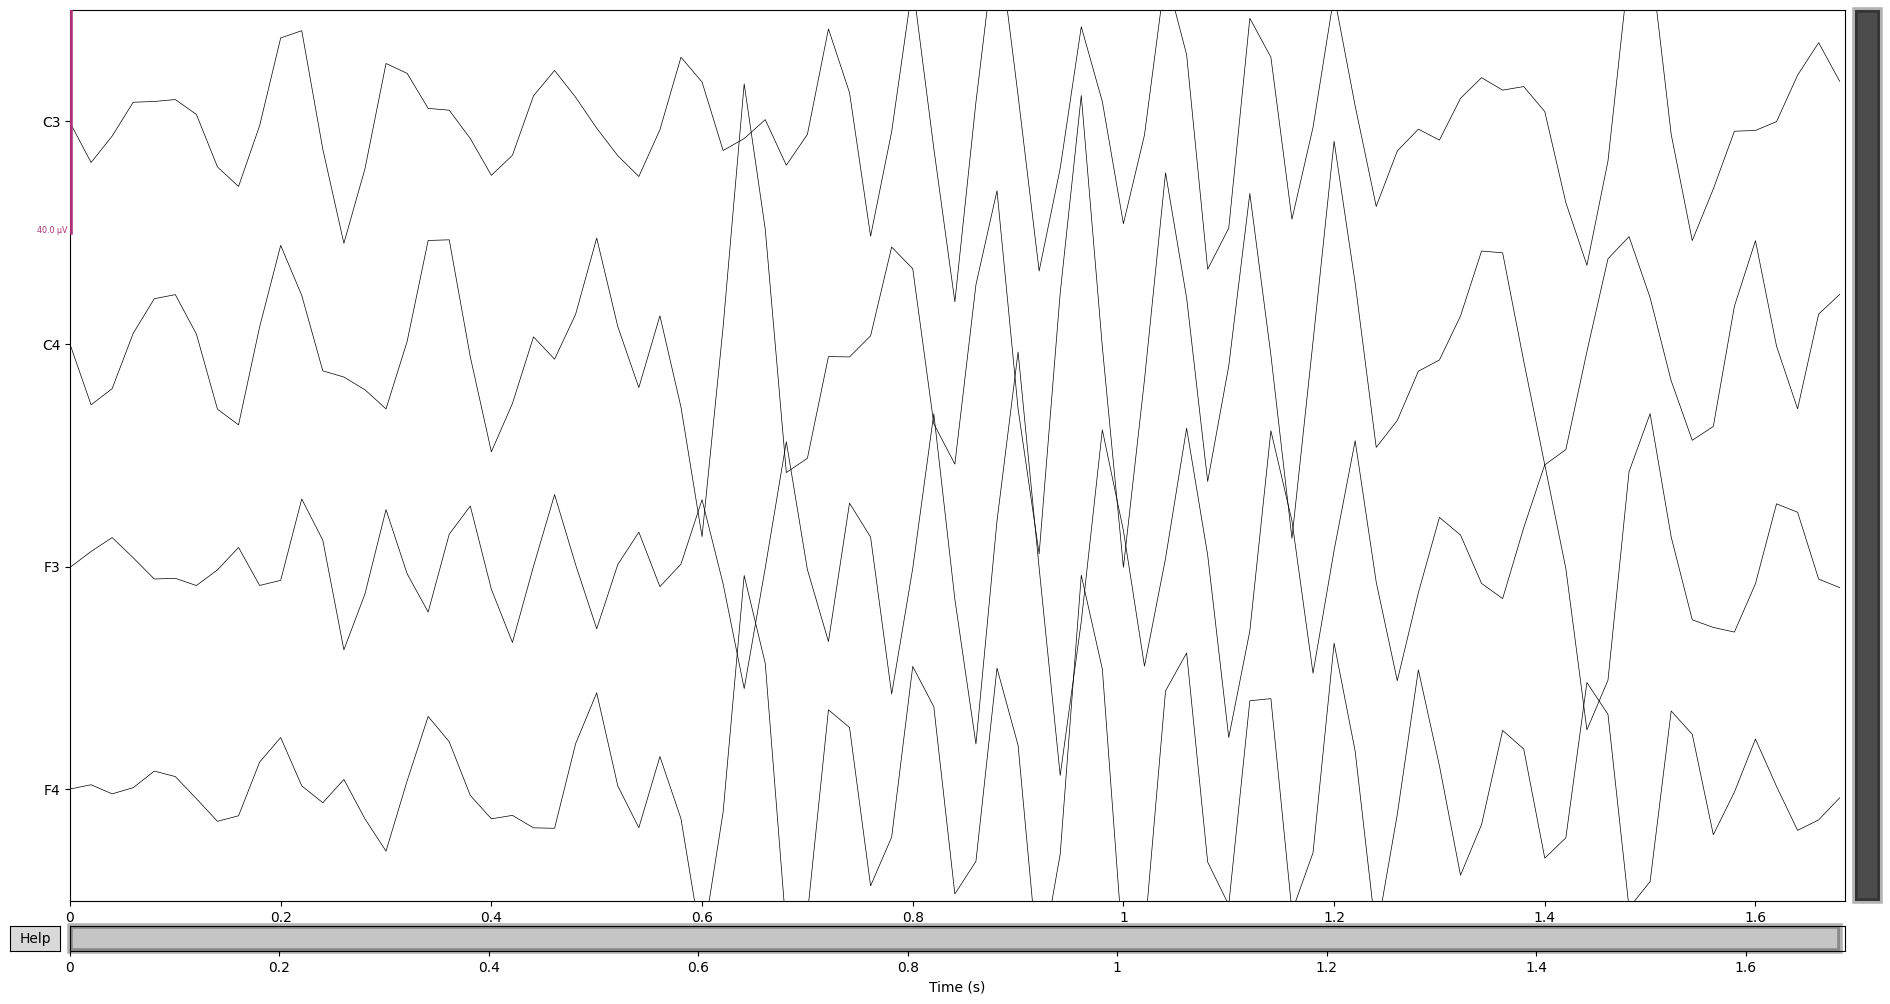

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


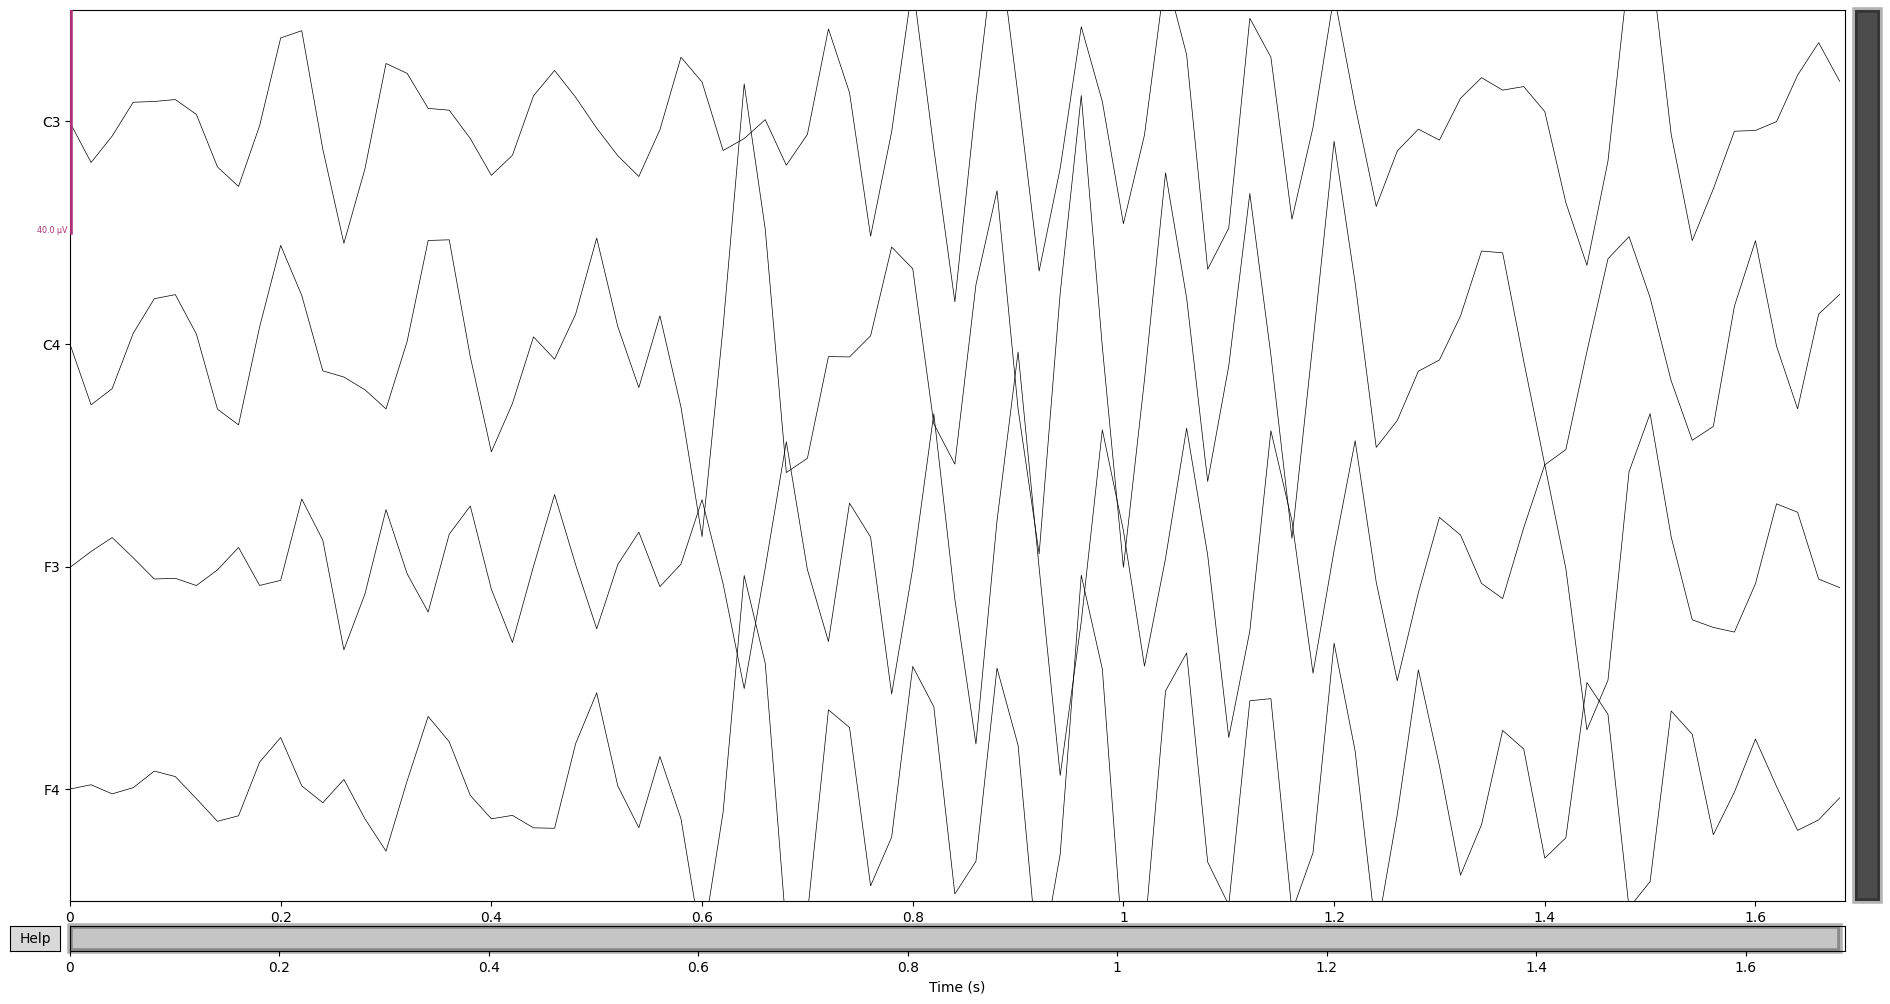

In [17]:
import pandas as pd

# Define EEG channels manually
EEG_CHANNELS = ['C3', 'C4',  'F3', 'F4']

# Load EDF
raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)

# Apply CAR across ALL EEG channels
raw_car = raw.copy()
raw_car.set_eeg_reference('average')

def plot_sample_windows(df, raw, label_value, n=2):
    """Plot `n` random EEG-only segments with or without spindles"""
    sample = df[df['label'] == label_value].sample(n)

    for _, row in sample.iterrows():
        start = 1883.163
        stop = 1884.853

        # Crop window
        segment = raw.copy().crop(tmin=start, tmax=stop)

        # Pick only EEG channels manually
        existing_eeg = [ch for ch in EEG_CHANNELS if ch in segment.ch_names]
        segment.pick_channels(existing_eeg)
        #Bandpass filter to spindle frequency (12‚Äì15 Hz)
        segment.filter(l_freq=7.0, h_freq=15.0, fir_design='firwin', verbose=False)

        # Plot
        # Plot
        label_name = 'Spindle' if label_value else 'No Spindle'
        segment.plot(
    scalings=dict(eeg=20e-6),        # control vertical amplitude (20 ¬µV)
    remove_dc=True,                  # center each signal
    title=f"{label_name} | Bandpassed 12‚Äì15 Hz\n{start:.2f}‚Äì{stop:.2f}s",
    show_scrollbars=True,           # allow vertical scroll
    n_channels=10,                  # limit number shown at once
    duration=10                     # seconds per screen
)



# Example usage (assuming segments and labels already created)
df = pd.DataFrame({
    "start_sec": [s[0] for s in segments],
    "end_sec": [s[1] for s in segments],
    "label": labels
})

plot_sample_windows(df, raw, label_value=0, n=2)  # No spindle
plot_sample_windows(df, raw, label_value=1, n=2)  # Spindle



In [15]:
from mne.filter import filter_data
from sklearn.preprocessing import StandardScaler

X = []  # Features (preprocessed windows)
y = []  # Labels

# Selected channels to cover major spindle areas
channel_names = ['F3', 'F4', 'C3', 'C4', 'P3', 'P4']

#for idx, row in df.iterrows():
for idx, row in df.head(10).iterrows():
    start = row['start_sec']
    stop = row['end_sec']
    label = row['label']

    # Crop EEG window
    segment = raw.copy().crop(tmin=start, tmax=stop)
    
    # Pick only our selected EEG channels
    try:
        segment.pick(channel_names)
        data = segment.get_data()
    except ValueError as e:
        print(f"Skipping segment {start}-{stop}: {e}")
        continue

    # Bandpass filter (1‚Äì30 Hz)
    filtered = filter_data(data, sfreq, l_freq=5.0, h_freq=30.0, filter_length='auto', verbose=False)# length warning came 

    # Normalize (z-score per channel)
    normalized = StandardScaler().fit_transform(filtered.T).T

    X.append(normalized)
    y.append(label)

X = np.array(X)  # shape: (n_windows, n_channels, n_samples)
y = np.array(y)
print(f"Segment length: {data.shape[1]} samples")

print("Preprocessing done.")
#print(f"EEG shape: {X.shape}, Label counts: {np.bincount(y)}")
print(f"EEG shape: {X.shape}, Label counts: {np.bincount(y.astype(int))}")


Segment length: 4001 samples
Preprocessing done.
EEG shape: (10, 6, 4001), Label counts: [10]


In [ ]:
chunk_size = 5

X = []
y = []

for start_idx in range(0, len(df), chunk_size):
    end_idx = start_idx + chunk_size
    chunk = df.iloc[start_idx:end_idx]

    for _, row in chunk.iterrows():
        start = row['start_sec']
        stop = row['end_sec']
        label = row['label']
        
        try:
            segment = raw.copy().crop(tmin=start, tmax=stop)
            segment.pick(['F3', 'F4', 'C3', 'C4', 'P3', 'P4'])
            data = segment.get_data()
        except Exception as e:
            print(f"Skipping {start}-{stop}: {e}")
            continue

        # Filter and normalize
        filtered = filter_data(data, sfreq, l_freq=1.0, h_freq=30.0, filter_length='auto', verbose=False)
        normalized = StandardScaler().fit_transform(filtered.T).T

        X.append(normalized)
        y.append(label)

    print(f"‚úÖ Processed chunk: {start_idx}‚Äì{end_idx}")

X = np.array(X)
y = np.array(y).astype(int)
np.save('data/X_windows.npy', X)
np.save('data/y_labels.npy', y)


‚úÖ Processed chunk: 0‚Äì5
‚úÖ Processed chunk: 5‚Äì10
‚úÖ Processed chunk: 10‚Äì15
‚úÖ Processed chunk: 15‚Äì20
‚úÖ Processed chunk: 20‚Äì25
‚úÖ Processed chunk: 25‚Äì30
‚úÖ Processed chunk: 30‚Äì35
‚úÖ Processed chunk: 35‚Äì40
‚úÖ Processed chunk: 40‚Äì45
‚úÖ Processed chunk: 45‚Äì50
‚úÖ Processed chunk: 50‚Äì55
‚úÖ Processed chunk: 55‚Äì60
‚úÖ Processed chunk: 60‚Äì65


In [10]:

print("‚úÖ", X.shape, y.shape)
# Expected: (17531, 6, 5120) or similar


‚úÖ (2156, 6, 4001) (2156,)


In [12]:
# train_cnn.py

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# --- Load data (replace with your actual path if needed) ---
X = np.load('data/X_windows.npy')  # shape: (N, 6, 512)
y = np.load('data/y_labels.npy')  # shape: (N,)

# Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Dataloaders
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

# --- Define CNN model ---
class SpindleCNN(nn.Module):
    def __init__(self):
        super(SpindleCNN, self).__init__()
        self.conv1 = nn.Conv1d(6, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.AdaptiveMaxPool1d(1)

        self.fc1 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        return torch.sigmoid(self.fc2(x))

# --- Training setup ---
model = SpindleCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            outputs = model(x_batch)
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.numpy())
            all_labels.extend(y_batch.numpy())
    print(classification_report(all_labels, all_preds))

# --- Train loop ---
epochs = 10
for epoch in range(epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
    evaluate(model, val_loader)


Epoch 1/10, Loss: 0.4836
              precision    recall  f1-score   support

         0.0       0.93      0.45      0.61        82
         1.0       0.89      0.99      0.94       350

    accuracy                           0.89       432
   macro avg       0.91      0.72      0.77       432
weighted avg       0.89      0.89      0.87       432

Epoch 2/10, Loss: 0.0944
              precision    recall  f1-score   support

         0.0       0.79      0.84      0.82        82
         1.0       0.96      0.95      0.96       350

    accuracy                           0.93       432
   macro avg       0.88      0.90      0.89       432
weighted avg       0.93      0.93      0.93       432

Epoch 3/10, Loss: 0.2824
              precision    recall  f1-score   support

         0.0       0.69      0.93      0.79        82
         1.0       0.98      0.90      0.94       350

    accuracy                           0.91       432
   macro avg       0.84      0.91      0.87       432

In [15]:
torch.save(model.state_dict(), "results/spindle_cnn.pth")


              precision    recall  f1-score   support

           0       0.96      0.97      0.97       425
           1       0.99      0.99      0.99      1731

    accuracy                           0.99      2156
   macro avg       0.98      0.98      0.98      2156
weighted avg       0.99      0.99      0.99      2156



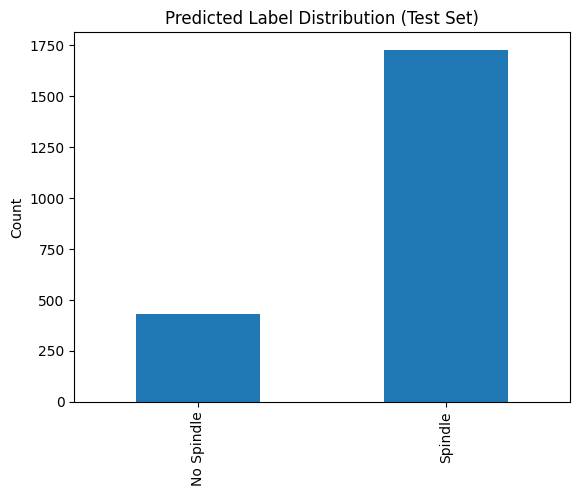

In [2]:
# predict_test_windows.ipynb

import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd

# --- Reload model class ---
class SpindleCNN(nn.Module):
    def __init__(self):
        super(SpindleCNN, self).__init__()
        self.conv1 = nn.Conv1d(6, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.AdaptiveMaxPool1d(1)

        self.fc1 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        return torch.sigmoid(self.fc2(x))

# --- Load model ---
model = SpindleCNN()
model.load_state_dict(torch.load("results/spindle_cnn.pth"))
model.eval()

# --- Load test data ---
X_test = np.load("data/X_windows.npy")
y_test = np.load("data/y_labels.npy")

# --- Predict in batches ---
batch_size = 500
preds = []
labels = []

for i in range(0, len(X_test), batch_size):
    x_batch = X_test[i:i+batch_size]
    y_batch = y_test[i:i+batch_size]
    x_tensor = torch.tensor(x_batch, dtype=torch.float32)
    with torch.no_grad():
        y_pred = model(x_tensor)
        y_pred = (y_pred > 0.5).float().numpy().squeeze()
        preds.extend(y_pred.tolist())
        labels.extend(y_batch.tolist())

# --- Evaluation ---
print(classification_report(labels, preds))

# --- Optional: Save result table ---
results_df = pd.DataFrame({"Predicted": preds, "True": labels})
results_df.to_csv("results/test_predictions.csv", index=False)

# --- Plot prediction counts ---
pd.Series(preds).value_counts().sort_index().plot(kind='bar')
plt.xticks([0, 1], ['No Spindle', 'Spindle'])
plt.title("Predicted Label Distribution (Test Set)")
plt.ylabel("Count")
plt.show()


In [3]:
import json
import numpy as np
import pandas as pd

# --- Load predicted results ---
pred_df = pd.read_csv("results/test_predictions.csv")

# Add start/end seconds for each test window
test_starts = np.arange(3 * 3600, 6 * 3600, 1.0)  # assuming step size = 1s
pred_df["start"] = test_starts[:len(pred_df)]
pred_df["end"] = pred_df["start"] + 2.0  # window length = 2s

# Keep only predicted spindle windows
predicted_spindles = pred_df[pred_df["Predicted"] == 1]

# --- Load ground truth spindle JSON ---
with open("data/labels/sleep_block_spindle_output_P002_1.json", "r") as f:
    spindle_data = json.load(f)

original_spindles = spindle_data["detected_spindles"]

# --- Compare ---
def overlaps(sp1, sp2):
    return sp1["start"] < sp2["end"] and sp1["end"] > sp2["start"]

match_count = 0
for _, pred_row in predicted_spindles.iterrows():
    pred_seg = {"start": pred_row["start"], "end": pred_row["end"]}
    if any(overlaps(pred_seg, sp) for sp in original_spindles):
        match_count += 1

print(f"‚úÖ Your model detected {len(predicted_spindles)} spindles.")
print(f"üéØ Of these, {match_count} overlap with spindles from the original model.")
print(f"üîç Match Rate: {match_count / len(predicted_spindles) * 100:.2f}%")


‚úÖ Your model detected 1727 spindles.
üéØ Of these, 973 overlap with spindles from the original model.
üîç Match Rate: 56.34%


In [ ]:

import mne
import matplotlib.pyplot as plt

# Load the raw EEG once (assumed done earlier)
raw = mne.io.read_raw_edf("data/raw/P002_1_raw.edf", preload=True)
sfreq = raw.info["sfreq"]

def plot_window_light(start_sec, end_sec, spindles_pred, spindles_old, channel='c4-ref', title="EEG Segment"):
    # Pick the channel data
    raw_crop = raw.copy().crop(tmin=start_sec, tmax=end_sec)
    raw_crop.pick_channels([channel])
    data, times = raw_crop.get_data(return_times=True)

    # Plot the signal
    plt.figure(figsize=(10, 3))
    plt.plot(times - start_sec, data[0], label=channel)

    # Add predicted spindles (green)
    for sp in spindles_pred:
        if sp['channel'] == channel and sp['start'] < end_sec and sp['end'] > start_sec:
            plt.axvspan(sp['start'] - start_sec, sp['end'] - start_sec, color='green', alpha=0.3, label='Predicted')

    # Add old spindles (red)
    for sp in spindles_old:
        if sp['channel'] == channel and sp['start'] < end_sec and sp['end'] > start_sec:
            plt.axvspan(sp['start'] - start_sec, sp['end'] - start_sec, color='red', alpha=0.3, label='Old Model')

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude (uV)")
    plt.title(title)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.tight_layout()
    plt.show()



Extracting EDF parameters from /home/subahini/Desktop/Master Project/spindle-project/notebooks/data/raw/P002_1_raw.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5967199  =      0.000 ... 29835.995 secs...


In [1]:
# Convert DataFrames to list of dicts
spindles_pred = predicted_spindles.to_dict('records')
spindles_old = original_spindles  # already a list of dicts

# Choose a segment with a known match
match_example = predicted_spindles[predicted_spindles["start"].between(10820, 10825)].iloc[0]
start = match_example["start"] - 5
end = match_example["end"] + 5

plot_window(start, end, spindles_pred, spindles_old, title="Matched Spindle")


NameError: name 'predicted_spindles' is not defined

In [6]:
X_reshaped = X[:, np.newaxis, :, :]  # Shape becomes (N, 1, 16, 512)


In [1]:
# train_2dcnn.py

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# --- Load preprocessed EEG data ---
X = np.load('data/X_windows.npy')      # Shape: (N, 16, 512)
y = np.load('data/y_labels.npy')       # Shape: (N,)

# --- Reshape for 2D CNN ---
X = X[:, np.newaxis, :, :]  # Shape: (N, 1, 16, 512)

# --- Convert to torch tensors ---
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# --- Train-validation split ---
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# --- Dataloaders ---
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

# --- Define 2D CNN Model ---
class Spindle2DCNN(nn.Module):
    def __init__(self):
        super(Spindle2DCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(3, 7), padding=(1, 3))
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d((1, 2))

        self.conv2 = nn.Conv2d(16, 32, kernel_size=(3, 5), padding=(1, 2))
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d((2, 2))

        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1))
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.AdaptiveMaxPool2d((1, 1))

        self.fc1 = nn.Linear(64, 32)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        return torch.sigmoid(self.fc2(x))

# --- Model, loss, optimizer ---
model = Spindle2DCNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# --- Evaluation helper ---
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            outputs = model(x_batch)
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.numpy())
            all_labels.extend(y_batch.numpy())
    print(classification_report(all_labels, all_preds))

# --- Training loop ---
epochs = 10
for epoch in range(epochs):
    model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
    evaluate(model, val_loader)


Epoch 1/10, Loss: 0.4163
              precision    recall  f1-score   support

         0.0       0.92      0.13      0.23        82
         1.0       0.83      1.00      0.91       350

    accuracy                           0.83       432
   macro avg       0.87      0.57      0.57       432
weighted avg       0.85      0.83      0.78       432

Epoch 2/10, Loss: 0.4488
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.84        82
         1.0       0.97      0.96      0.96       350

    accuracy                           0.94       432
   macro avg       0.89      0.91      0.90       432
weighted avg       0.94      0.94      0.94       432

Epoch 3/10, Loss: 0.3498
              precision    recall  f1-score   support

         0.0       0.86      0.88      0.87        82
         1.0       0.97      0.97      0.97       350

    accuracy                           0.95       432
   macro avg       0.91      0.92      0.92       432

In [3]:
# Save the model
torch.save(model.state_dict(), "models/spindle_2dcnn.pth")


In [4]:
model = Spindle2DCNN()
model.load_state_dict(torch.load("models/spindle_2dcnn.pth"))
model.eval()


Spindle2DCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 7), stride=(1, 1), padding=(1, 3))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 5), stride=(1, 1), padding=(1, 2))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): AdaptiveMaxPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

In [7]:
with torch.no_grad():
    test_tensor = torch.tensor(X_test, dtype=torch.float32)  # (N, 1, 16, 512)
    outputs = model(test_tensor)
    predictions = (outputs > 0.5).int().squeeze().numpy()


NameError: name 'X_test' is not defined

In [ ]:
# test_2dcnn.py

import torch
import numpy as np
from train_2dcnn import Spindle2DCNN  # assuming it's in the same folder

# --- Load model ---
model = Spindle2DCNN()
model.load_state_dict(torch.load("models/spindle_2dcnn.pth"))
model.eval()

# --- Load new data (must be preprocessed + reshaped) ---
X_test = np.load("data/X_test.npy")  # shape: (N, 16, 512)
X_test = X_test[:, np.newaxis, :, :]  # shape: (N, 1, 16, 512)
X_tensor = torch.tensor(X_test, dtype=torch.float32)

# --- Predict ---
with torch.no_grad():
    outputs = model(X_tensor)
    predictions = (outputs > 0.5).int().squeeze().numpy()

# Save results
np.save("results/predicted_labels.npy", predictions)
print("‚úÖ Predictions saved.")


In [ ]:
# Initialize and load your data
loader = EEGDataLoader("your_file.edf")  # Supports .edf, .mat, .fif, .csv, .npy
loader.load_data()

# Get a random 5-minute window
window_data, start_time, end_time = loader.get_random_5min_window(seed=42)

# Plot it
loader.plot_window(window_data, start_time)              
# --- Load EEG ---
raw = mne.io.read_raw_edf(edf_path, preload=True)
sfreq = raw.info['sfreq']
total_duration_sec = raw.n_times / sfreq
print(f"EEG Duration: {total_duration_sec / 3600:.2f} hours")

